## 1. Packages & Parallel Processing Setup

In [ ]:
using Distributed
if nworkers() == 1
    addprocs(10) # adjust number of workers as needed i.e. available CPU cores
end
using Plots
using Colors
using ProgressMeter
@everywhere begin
    using Agents
    using Distributions
    using Random
end

## 2. Agent definition


In [2]:
@everywhere begin
    @agent struct Player(GridAgent{2})
        old_norm::Int64
        norm::Int64
        groupID::Int
        payoff::Float64
    end
end

## 3. Model initialization



In [3]:
@everywhere begin
    function initialize(;
        M=30,
        init_norm1_groupA=0.6,
        init_norm1_groupB=0.4,
        surplus_benefit=7.0,
        norm1_share=0.7,
        prob_outgroup_interaction=0.9,
        prob_outgroup_observation=0.0,
        asymm=false,
    )
        space = GridSpaceSingle((M, M); periodic=false, metric=:manhattan)
        properties = Dict(
            :M => M,
            :init_norm1_groupA => init_norm1_groupA,
            :init_norm1_groupB => init_norm1_groupB,
            :surplus_benefit => surplus_benefit,
            :norm1_share => norm1_share,
            :prob_outgroup_interaction => prob_outgroup_interaction,
            :prob_outgroup_observation => prob_outgroup_observation,
            :asymm => asymm
        )
        model = StandardABM(Player, space;
            properties=properties,
            scheduler=Schedulers.Randomly(),
            (model_step!)=model_step!
        )
        half_x = div(M, 2)
        for y in 1:M
            for x in 1:M
                group_id = (x <= half_x) ? 0 : 1 # 0 for Group A, 1 for Group B
                init_prob = (group_id == 0) ? init_norm1_groupA : init_norm1_groupB # initial probability of norm1 based on group
                s = rand() < init_prob ? 1 : 0 # assign norm based on initial probability
                add_agent_single!(model; old_norm=s, norm=s, groupID=group_id, payoff=0.0)
            end
        end

        return model
    end
end


## 4. Helper- Calculate and assign payoffs for groups

In [ ]:
@everywhere begin
    function update_group!(group_idx, out_idx, agents, prob_out, pay_high, pay_low)
        num_in = length(group_idx)
        if num_in == 0
            return
        end
        # Calculate proportions of norm 1 in ingroup and outgroup
        s_in = 0.0
        @inbounds @simd for idx in group_idx
            s_in += agents[idx].norm
        end
        p_in = s_in / num_in
        # Calculate proportion of norm 1 in outgroup
        num_out = length(out_idx)
        p_out = 0.0
        if num_out > 0
            s_out = 0.0
            @inbounds @simd for idx in out_idx
                s_out += agents[idx].norm
            end
            p_out = s_out / num_out
        end
        # Calculate expected payoffs for each norm
        norm1_payoff = prob_out * ((1 - p_out) * (1 + pay_high) + (p_out)) +
                       (1 - prob_out) * ((1 - p_in) * (1 + pay_high) + (p_in)) # payoff for norm 1

        norm2_payoff = prob_out * (((1 - p_out)) + (p_out * (1 + pay_low))) +
                       (1 - prob_out) * (((1 - p_in)) + (p_in * (1 + pay_low))) # payoff for norm 2

        # Assign payoffs
        @inbounds for idx in group_idx
            a = agents[idx]
            a.payoff = (a.norm == 1) ? norm1_payoff : norm2_payoff
        end
    end
end

## 5. Dynamics - model_step!

In [ ]:
@everywhere begin
    function model_step!(model)

        agents = collect(allagents(model))
        n = length(agents)

        if model.asymm # copy current norm to old_norm
            @inbounds for i in 1:n
                agents[i].old_norm = agents[i].norm
            end
        end

        group0_idx = Int[]
        group1_idx = Int[]


        # Separate agents by group
        @inbounds for i in 1:n
            if agents[i].groupID == 0
                push!(group0_idx, i)
            else
                push!(group1_idx, i)
            end
        end

        prob_out = model.prob_outgroup_interaction
        surplus = model.surplus_benefit
        share = model.norm1_share

        pay_high = share * surplus # payoff for coordinating on the more common norm
        pay_low = (1 - share) * surplus # payoff for coordinating on the less common norm

        update_group!(group0_idx, group1_idx, agents, prob_out, pay_high, pay_low)
        update_group!(group1_idx, group0_idx, agents, prob_out, pay_high, pay_low)


        m = model.prob_outgroup_observation

        # Social learning 
        for idx in randperm(n)
            a = agents[idx]
            my_group = a.groupID
            other_group = (rand() < m) ? (my_group + 1) % 2 : my_group # decide whether to observe ingroup or outgroup

            # Get indices of the chosen group
            group_idxs = (other_group == 0) ? group0_idx : group1_idx
            if isempty(group_idxs)
                continue
            end


            if other_group == my_group && length(group_idxs) == 1
                continue
            end

            cand_idx = 0
            while true
                cand_idx = rand(group_idxs)
                if other_group != my_group || agents[cand_idx].id != a.id
                    break
                end
            end
            # Calculate probability of copying the observed agent's norm
            observed = agents[cand_idx]
            payoff_diff = observed.payoff - a.payoff
            prob_copy = 1 / (1 + exp(-payoff_diff))
            # Update norm based on copying probability
            if rand() < prob_copy
                a.norm = model.asymm ? observed.old_norm : observed.norm
            end
        end
    end
end


## 6. Helper- running simulation batches

In [21]:
@everywhere function run_trajectory(; 
    M=30,
    init_norm1_groupA=0.6,
    init_norm1_groupB=0.4,
    surplus_benefit=7.0,
    norm1_share=0.7,
    prob_outgroup_interaction=0.9,
    prob_outgroup_observation=0.0, 
    asymm=false,
    max_steps=300
)
    model = initialize(
        M=M,
        init_norm1_groupA=init_norm1_groupA,
        init_norm1_groupB=init_norm1_groupB,
        surplus_benefit=surplus_benefit,
        norm1_share=norm1_share,
        prob_outgroup_interaction=prob_outgroup_interaction,
        prob_outgroup_observation=prob_outgroup_observation,
        asymm=asymm
    )
    times = Int[]
    groupA_freq = Float64[]
    groupB_freq = Float64[]

    push!(times, 0)
    groupA = filter(a -> a.groupID == 0, collect(allagents(model)))
    groupB = filter(a -> a.groupID == 1, collect(allagents(model)))
    push!(groupA_freq, mean(a -> a.norm, groupA))
    push!(groupB_freq, mean(a -> a.norm, groupB))

    step = 0
    while step < max_steps
        step!(model, 1)
        step += 1
        push!(times, step)
        groupA = filter(a -> a.groupID == 0, collect(allagents(model)))
        groupB = filter(a -> a.groupID == 1, collect(allagents(model)))
        push!(groupA_freq, mean(a -> a.norm, groupA))
        push!(groupB_freq, mean(a -> a.norm, groupB))
    end

    return (times, groupA_freq, groupB_freq)
end

@everywhere begin
    function run_trajectory_trials(;
        n_trials=50,
        M=30,
        init_norm1_groupA=0.6,
        init_norm1_groupB=0.4,
        surplus_benefit=7.0,
        norm1_share=0.7,
        prob_outgroup_interaction=0.9,
        prob_outgroup_observation=0.0,  # m 
        asymm=asymm,
        max_steps=300
    )
        trajs = []
        for i in 1:n_trials
            traj = run_trajectory(
                M=M,
                init_norm1_groupA=init_norm1_groupA,
                init_norm1_groupB=init_norm1_groupB,
                surplus_benefit=surplus_benefit,
                norm1_share=norm1_share,
                prob_outgroup_interaction=prob_outgroup_interaction,
                prob_outgroup_observation=prob_outgroup_observation,
                asymm=asymm,
                max_steps=max_steps
            )
            push!(trajs, traj)
        end
        return trajs
    end
end

## 7. Helper- post-sim group processing

In [22]:
# trajs is a vector of (times, groupA, groupB)
function final_AB_from_trajs(trajs)
    A = Float64[]
    B = Float64[]
    for (_, groupA, groupB) in trajs
        push!(A, groupA[end])
        push!(B, groupB[end])
    end
    return A, B
end

# Extract results from results_dict for given tag and xs
function extract_results(results_dict, tag::Symbol, xs::AbstractVector{<:Float64})
    x_all = Float64[]
    A_all = Float64[]
    B_all = Float64[]

    for x in xs
        A_vec, B_vec = results_dict[(tag, x)]
        append!(x_all, fill(x, length(A_vec)))
        append!(A_all, A_vec)
        append!(B_all, B_vec)
    end

    return (xs=collect(xs), x_all=x_all, A_all=A_all, B_all=B_all)
end



extract_results (generic function with 1 method)

## 9. Helper- Build plots

In [23]:
function plot_panel(results_dict, xs; xlabel_str)
    x_all = Float64[]
    A_all = Float64[]
    B_all = Float64[]

    # collect all final freqs across all xs
    for x in xs
        trajs = results_dict[x]
        A_vec, B_vec = final_AB_from_trajs(trajs) 

        append!(x_all, fill(x, length(A_vec)))
        append!(A_all, A_vec)
        append!(B_all, B_vec)
    end

    # means at each x
    A_mean = [mean(A_all[x_all .== x]) for x in xs]
    B_mean = [mean(B_all[x_all .== x]) for x in xs]

    plt = plot()

    # choose colors for A and B
    colorA = :blue
    colorB = :orange

    # scatter “clouds”, same color as their line
    scatter!(plt, x_all, A_all;
             alpha = 0.25, ms = 3, label = "",
             markerstrokewidth = 0, color = colorA,fmt=:png,dpi=300)
    scatter!(plt, x_all, B_all;
             alpha = 0.25, ms = 3, label = "",
             markerstrokewidth = 0, color = colorB,fmt=:png,dpi=300)

    # mean curves
    plot!(plt, xs, A_mean; lw = 3, label = "type A", color = colorA, fmt=:png,dpi=300)
    plot!(plt, xs, B_mean; lw = 3, label = "type B", color = colorB, fmt=:png,dpi=300)

    xlabel!(plt, xlabel_str)
    ylabel!(plt, "mean frequency of norm 1")

    mm = Plots.mm
    plot!(plt;
        left_margin   = 8mm,
        right_margin  = 5mm,
        bottom_margin = 8mm,
        top_margin    = 5mm,
    )
    
    return plt
end


plot_panel (generic function with 1 method)

## 9. Parameter sweep settings and simulate


In [26]:
d_range     = 0.4:0.02:0.9      # x-axis for left panel - adjust as needed
gamma_range = 0.5:0.02:1.0      # x-axis for right panel - adjust as needed

# For these figures:
G_val   = 3.0           # surplus_benefit - adjust as needed
m_val   = 0.03          # prob_outgroup_observation - adjust as needed
gamma_fix = 0.5         # γ fixed when sweeping d - adjust as needed
d_fix     = 0.8         # d fixed when sweeping γ - adjust as needed
n_trials  = 50          # number of trials per parameter case - adjust as needed
M_val     = 30          # grid size - adjust as needed
max_steps = 300         # max steps per trajectory - adjust as needed


param_cases = NamedTuple[]


# figure 7.12
# left panel: vary d, hold γ fixed
for d in d_range
    push!(param_cases, (tag = :d,
                        x   = d,
                        prob_outgroup_interaction = d,
                        norm1_share = gamma_fix))
end

# right panel: vary γ, hold d fixed
for γ in gamma_range
    push!(param_cases, (tag = :gamma,
                        x   = γ,
                        prob_outgroup_interaction = d_fix,
                        norm1_share = γ))
end

# 3) Dicts to store trajectories
results_d      = Dict{Float64, Any}()   
results_gamma  = Dict{Float64, Any}()   

@info "Running batch experiments for d and gamma..."

progress_channel = RemoteChannel(() -> Channel{Int}(1000))
p = Progress(length(param_cases), dt=0.1, desc="Running batch trajectories")

@async begin
    for _ in progress_channel
        next!(p)
    end
end

# Run experiments in parallel over parameter cases
results_tuples = pmap(param_cases) do pc
    trajs = run_trajectory_trials(
        n_trials = n_trials,
        M = M_val,
        init_norm1_groupA = 0.6, # fixed initial norm freq for group A - adjust as needed
        init_norm1_groupB = 0.4, # fixed initial norm freq for group B - adjust as needed
        surplus_benefit   = G_val,
        norm1_share       = pc.norm1_share,
        prob_outgroup_interaction = pc.prob_outgroup_interaction,
        prob_outgroup_observation = m_val,
        asymm = false, # whether to use asymmetric updating - adjust as needed
        max_steps = max_steps
    )
    # progress tick
    remotecall_fetch(() -> put!(progress_channel, 1), 1)
    return (pc.tag, pc.x, trajs)
end

# Store results in appropriate dicts
for (tag, x, trajs) in results_tuples
    if tag == :d
        results_d[x] = trajs
    else
        results_gamma[x] = trajs
    end
end


[ Info: Running batch experiments for d and gamma...
Running batch trajectories 100%|█████████████████████████| Time: 0:00:08


## 10. Display plots



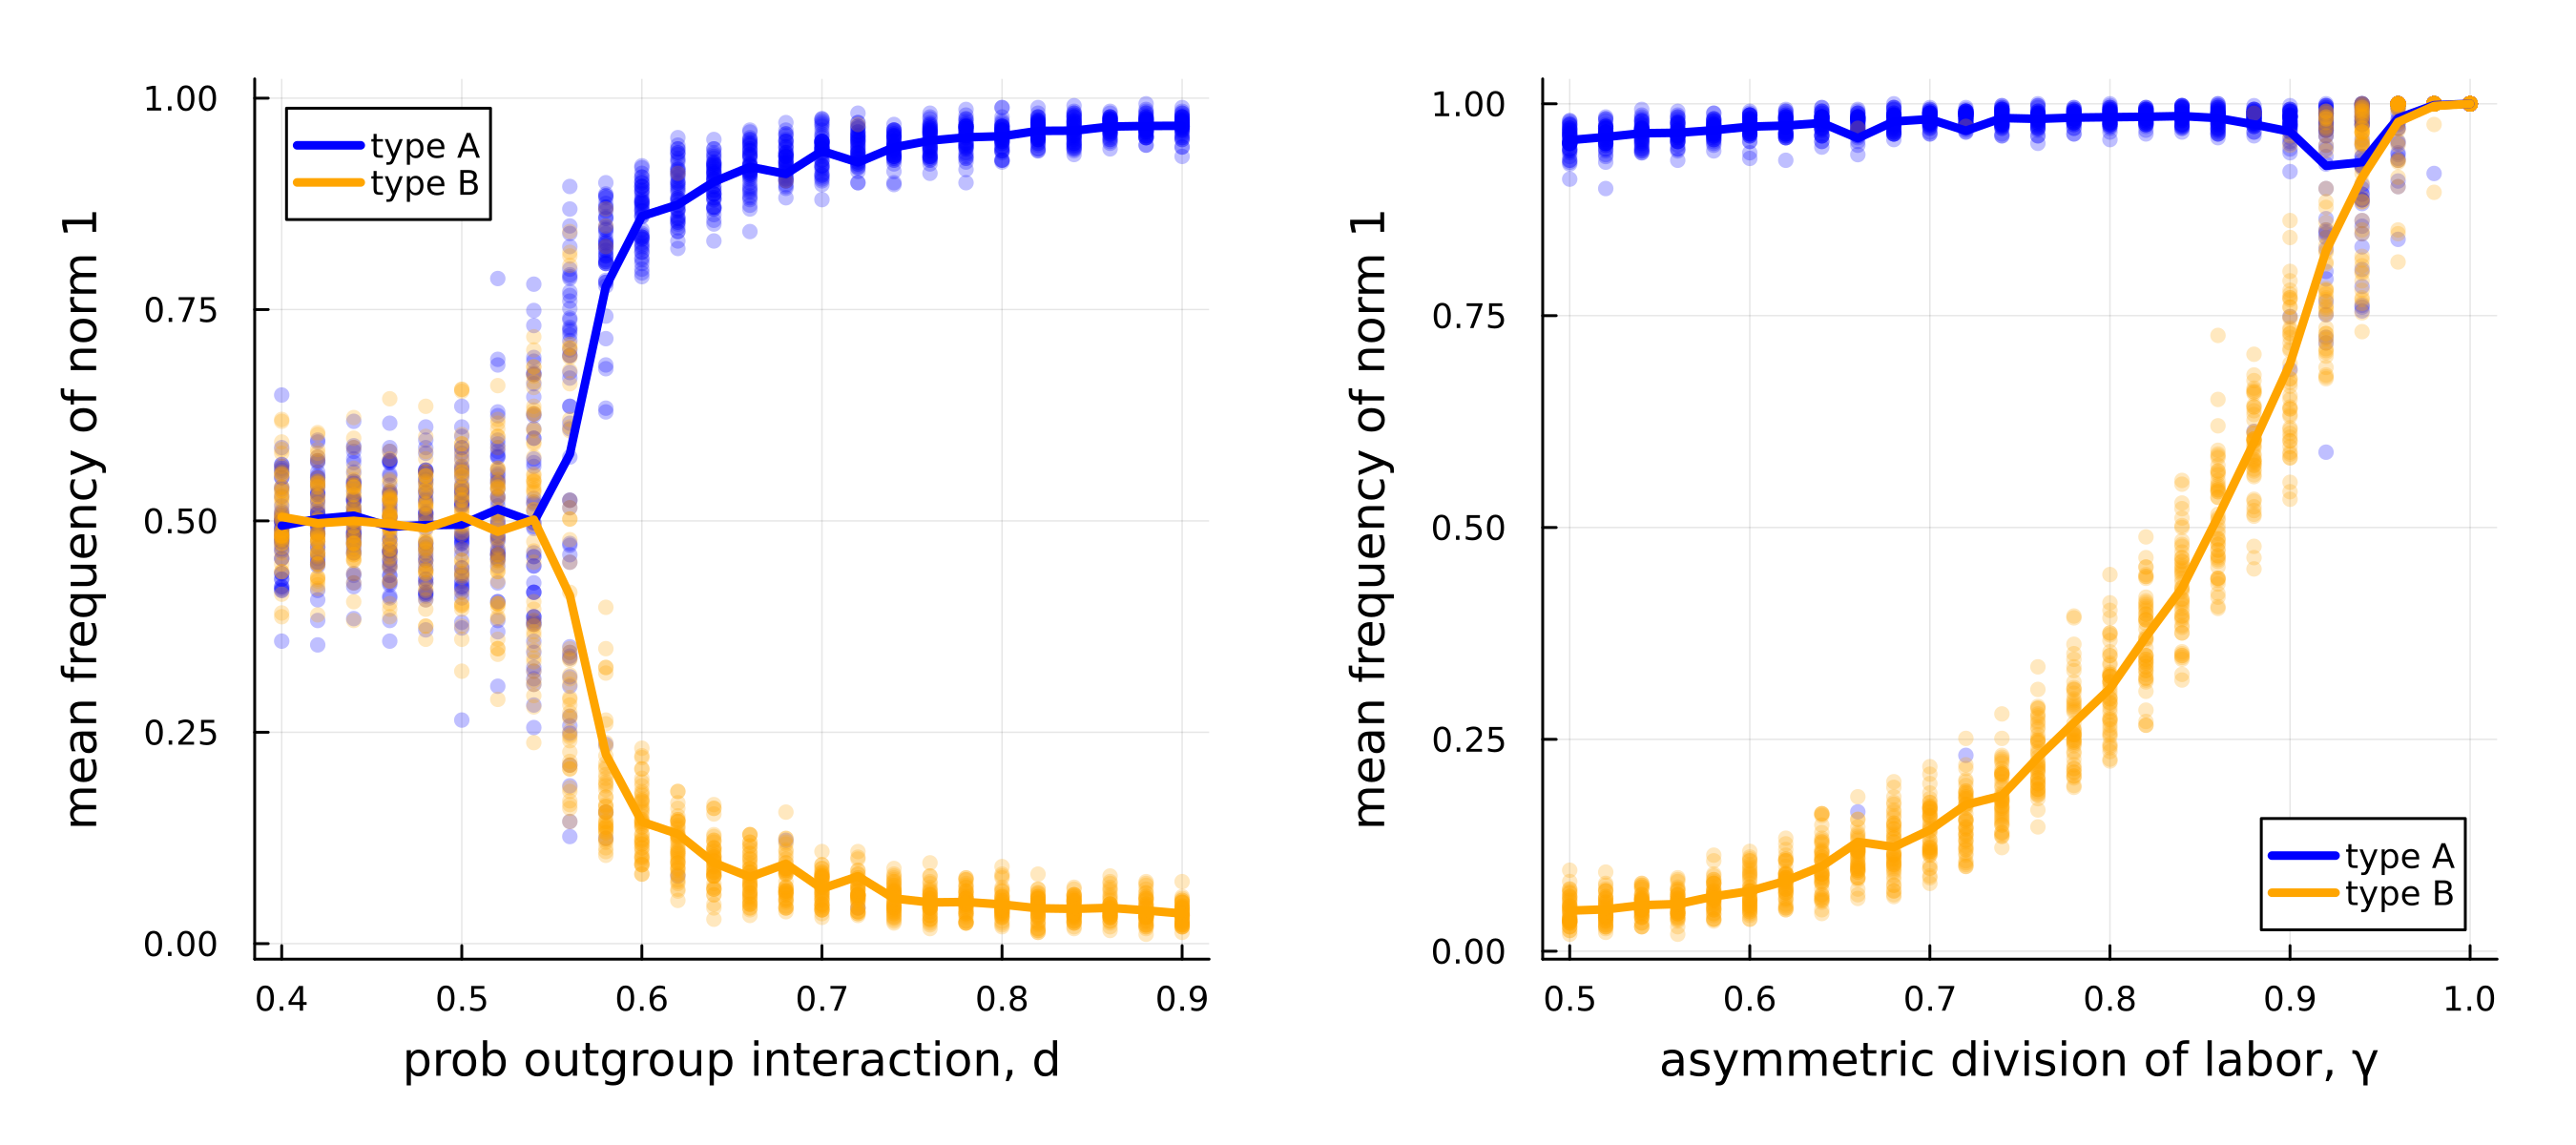

In [27]:
# left panel: sweep d
plt_left  = plot_panel(results_d, d_range;
                       xlabel_str = "prob outgroup interaction, d")

# right panel: sweep γ
plt_right = plot_panel(results_gamma, gamma_range;
                       xlabel_str = "asymmetric division of labor, γ")

final_plt = plot(plt_left, plt_right; layout = (1, 2), size = (900, 400))
display(final_plt)

